# Atrial Fibrillation Classification

The goal of this exercise is to train different conventional classification models to discriminate between atrial fibrillation and normal sinus rhythm from a sequence of interbeat intervals. We use interbeat intervals extracted from the Long Term AF Database (https://physionet.org/content/ltafdb/1.0.0/).

We will train the following models on windows of interbeat intervals:

* Decision tree
* Support vector machine (SVM)
* Naive Bayes

The models will be trained on simple features derived from each window of interbeat intervals.

First, we import all the required packages, define global constants, and seed the random number generators to obtain reproducible results.

In [2]:
%matplotlib widget


import operator
import pathlib
import warnings
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import seaborn as sns


DATA_FILE = pathlib.Path('../data/ltafdb_intervals.npz')
LOG_DIRECTORY = pathlib.Path('../logs/af_classification')

Then, we load the windows of interbeat intervals and the corresponding labels. We also load the record identifiers. They will help to avoid using intervals from the same record for both training and testing.

In [3]:
def load_data():
    with np.load(DATA_FILE) as data:
        intervals = data['intervals']
        labels = data['labels']
        identifiers = data['identifiers']
    return intervals, labels, identifiers


intervals, labels, identifiers = load_data()
targets = (labels == 'atrial_fibrillation').astype('float32')[:, None]
window_size = intervals.shape[1]

print(f'Number of windows: {intervals.shape[0]}')
print(f'Window size: {window_size}')
print(f'Window labels: {set(labels)}')

Number of windows: 25064
Window size: 32
Window labels: {'normal_sinus_rhythm', 'atrial_fibrillation'}


Here are a few examples of windows of interbeat intervals.

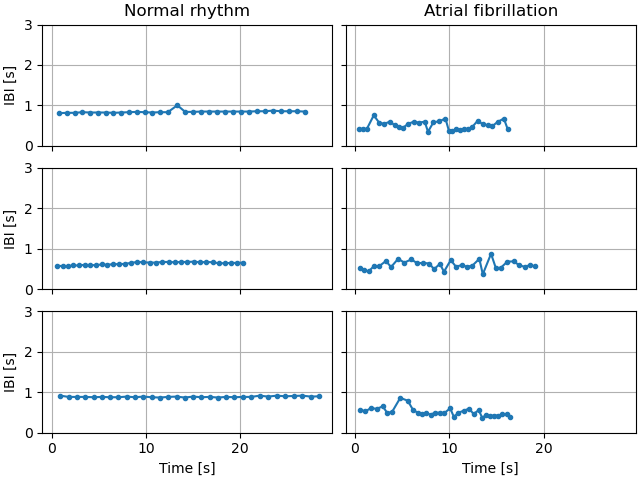

In [4]:
def plot_interval_examples(intervals, targets, n_examples=3):
    normal_indices = np.random.choice(np.flatnonzero(targets == 0.0), n_examples, replace=False)
    af_indices = np.random.choice(np.flatnonzero(targets == 1.0), n_examples, replace=False)
    
    def plot_intervals(ax, index):
        ax.plot(np.cumsum(intervals[index]), intervals[index], '.-')
        ax.grid(True)
    
    fig, axes = plt.subplots(n_examples, 2, sharex='all', sharey='all', squeeze=False, constrained_layout=True)
    for i in range(n_examples):
        plot_intervals(axes[i, 0], normal_indices[i])
        plot_intervals(axes[i, 1], af_indices[i])
    plt.setp(axes, ylim=(0.0, 3.0))
    plt.setp(axes[-1, :], xlabel='Time [s]')
    plt.setp(axes[:, 0], ylabel='IBI [s]')
    axes[0, 0].set_title('Normal rhythm')
    axes[0, 1].set_title('Atrial fibrillation')
    
    
plot_interval_examples(intervals, targets)

The next step is to split the dataset into subsets for training, validation, and testing stratified by labels.

In [5]:
def split_data(identifiers, intervals, targets):
    splitter = sklearn.model_selection.StratifiedGroupKFold(n_splits=5)
    indices = list(map(operator.itemgetter(1), splitter.split(intervals, targets, identifiers)))
    i_train = np.hstack(indices[:-2])
    i_val = indices[-2]
    i_test = indices[-1]
    
    assert not (set(identifiers[i_train]) & set(identifiers[i_val]))
    assert not (set(identifiers[i_train]) & set(identifiers[i_test]))
    assert not (set(identifiers[i_val]) & set(identifiers[i_test]))
    assert set(identifiers[i_train]) | set(identifiers[i_val]) | set(identifiers[i_test]) == set(identifiers)
    
    return i_train, i_val, i_test


i_train, i_val, i_test = split_data(identifiers, intervals, targets)


def build_summary(subsets, targets):
    data = []
    for subset, y in zip(subsets, targets):
        data.append({
            'subset': subset,
            'total_count': y.size,
            'normal_count': np.sum(y == 0.0),
            'af_count': np.sum(y == 1.0),
            'normal_proportion': np.mean(y == 0.0),
            'af_proportion': np.mean(y == 1.0),
        })
    return pd.DataFrame(data)


IPython.display.display(build_summary(('training', 'validation', 'testing'), (targets[i_train], targets[i_val], targets[i_test])))

subset  total_count  normal_count  af_count  normal_proportion  \
0    training        15000          6919      8081           0.461267   
1  validation         4964          2365      2599           0.476430   
2     testing         5100          2311      2789           0.453137   

   af_proportion  
0       0.538733  
1       0.523570  
2       0.546863

To better understand the dataset, we extract two features from each window of interbeat intervals: the mean and the standard deviation. We then plot these two features for the two classes.

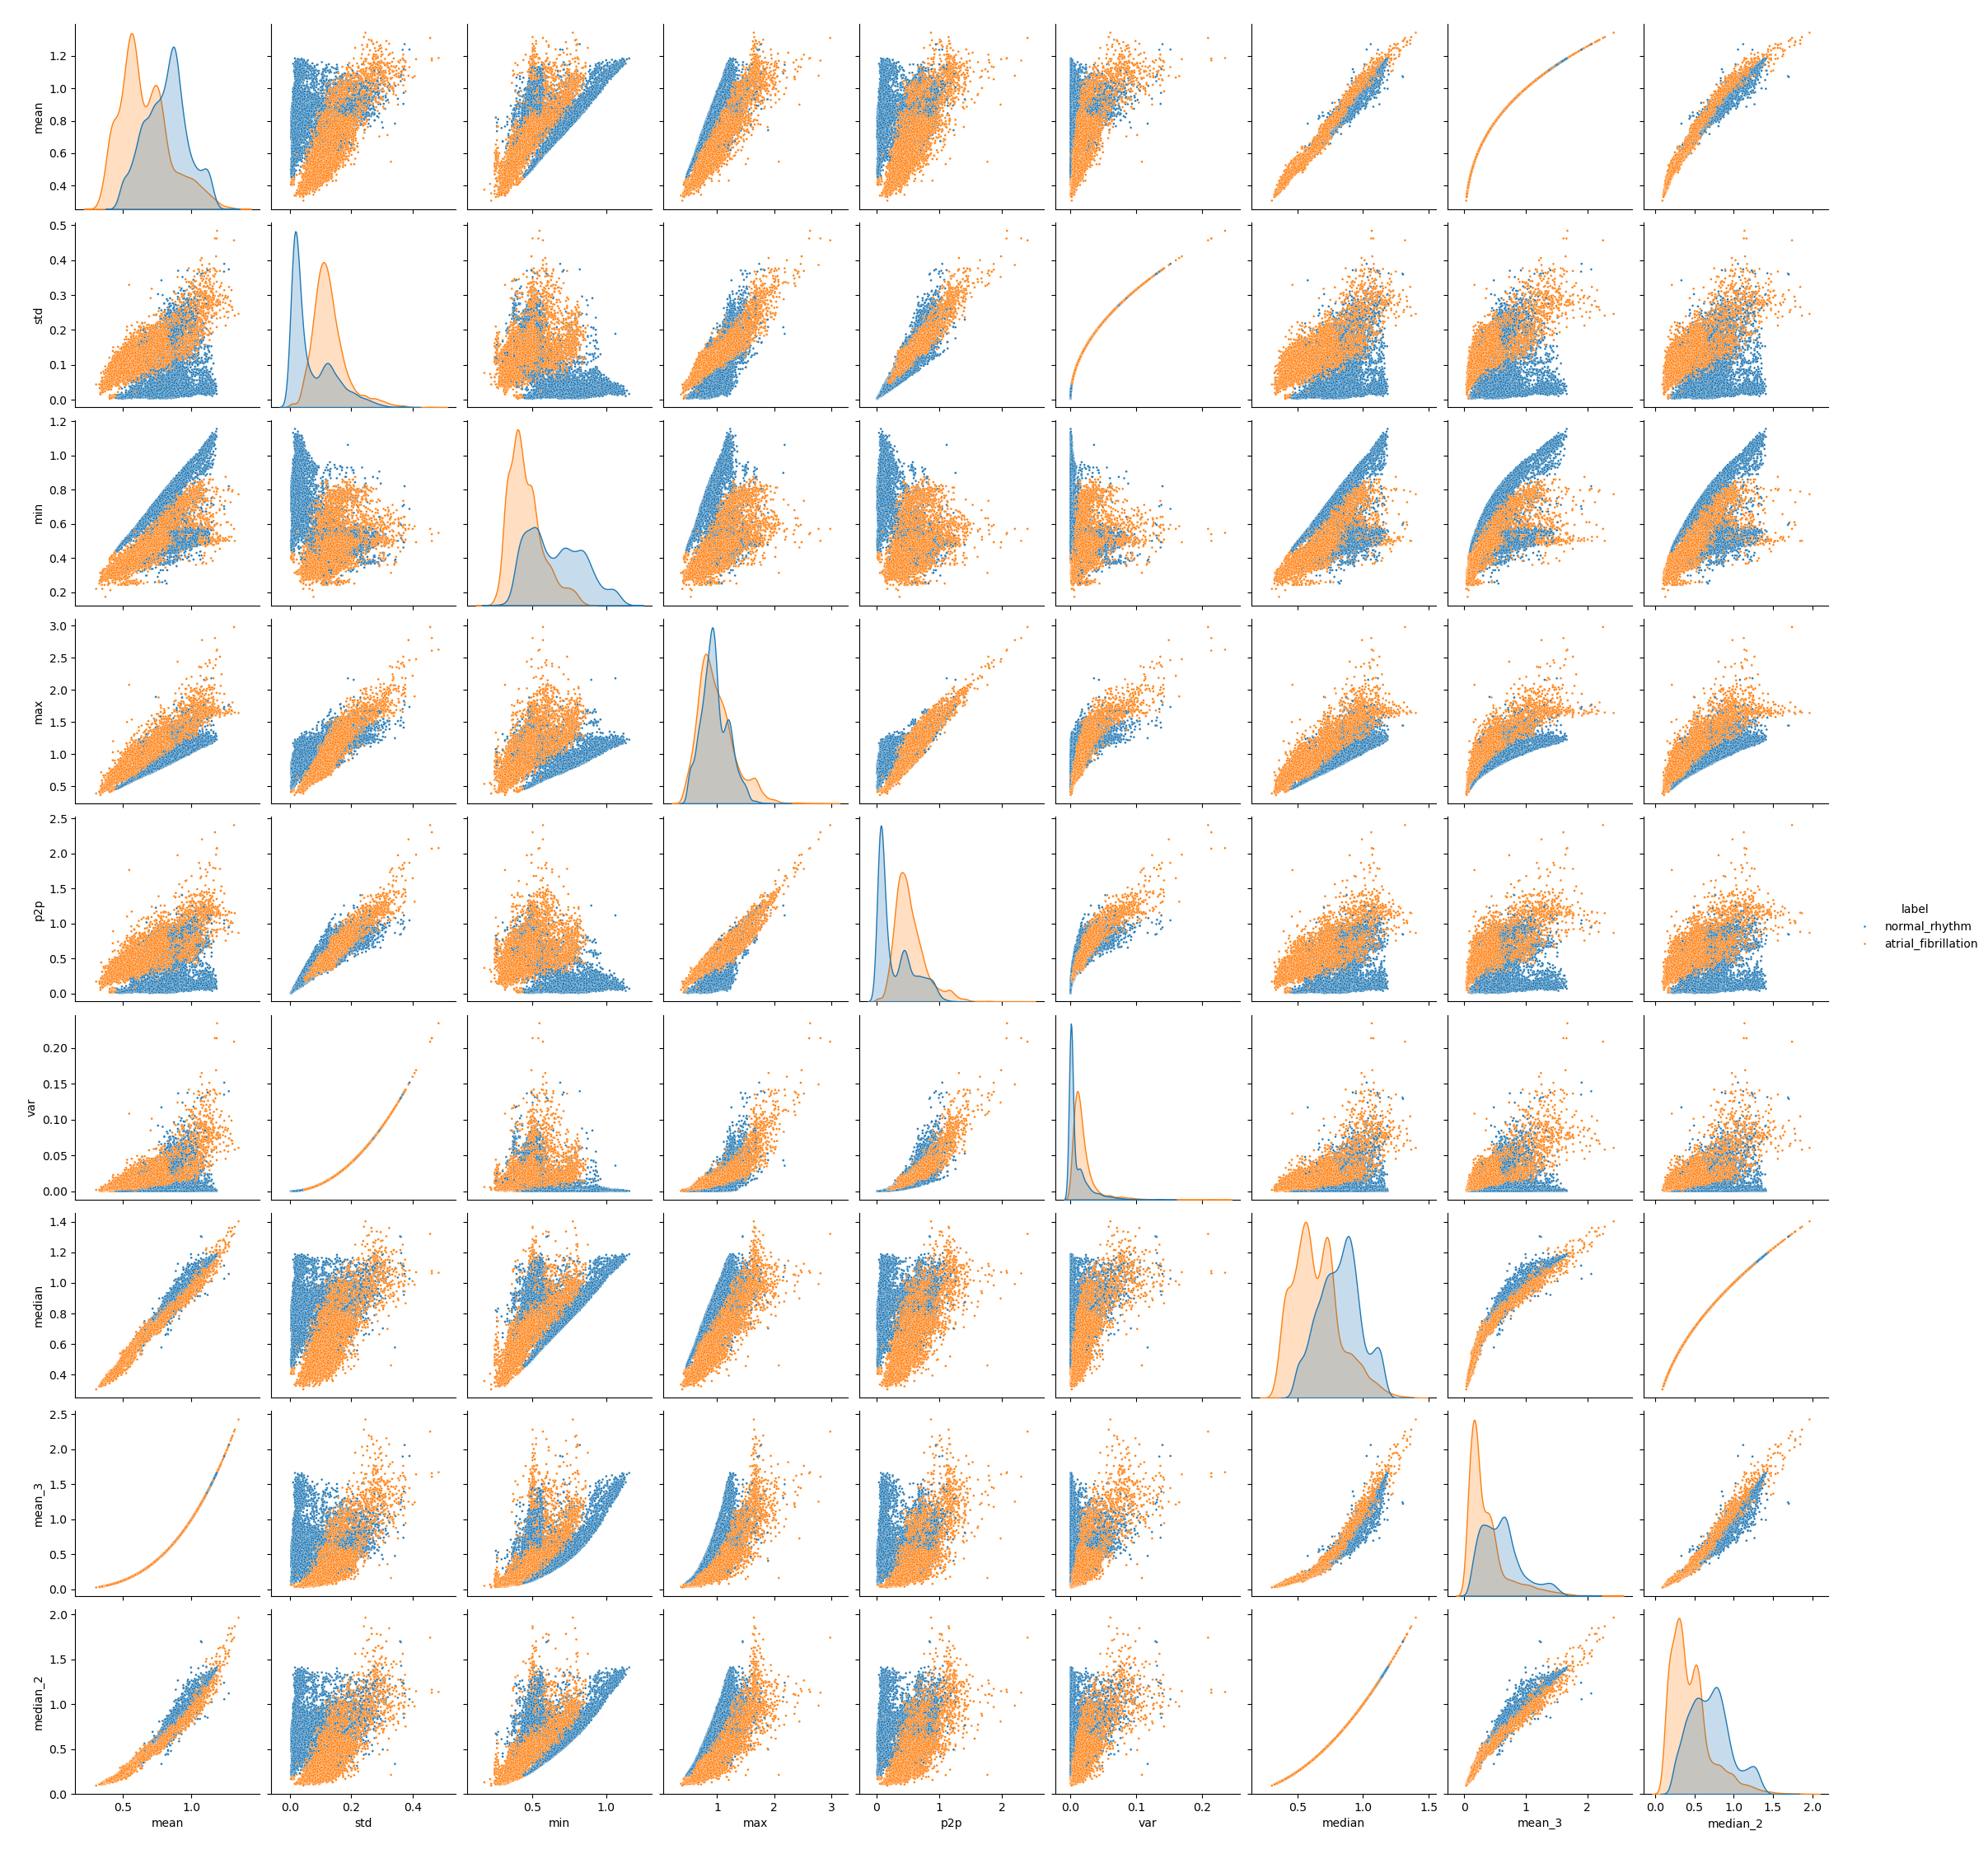

In [6]:
f_mean = np.mean(intervals, axis=1)
f_std = np.std(intervals, axis=1)
f_min = np.min(intervals, axis=1)
f_max = np.max(intervals, axis=1)
f_median = np.median(intervals, axis=1)
features = pd.DataFrame({
    'mean': f_mean,
    'std': f_std,
    'min': f_min,
    'max': f_max, 
    'p2p': f_max - f_min, 
    'var': np.power(f_std, 2),
    'median': f_median,
    'mean_3': np.power(f_mean, 3),
    'median_2': np.power(f_median, 2),
    
})


def plot_features(f, y):
    data = f.copy()
    data['label'] = y.ravel()
    data['label'] = data['label'].map({0.0: 'normal_rhythm', 1.0: 'atrial_fibrillation'})
    sns.pairplot(data, hue='label', plot_kws={'s': 4})


plot_features(features.iloc[i_train], targets[i_train])

It is also possible to select the most relevant features using various methods. Here, we define implement three fature selection techniques: lasso, univariate, hybrid. 

In [7]:
class FeatureSelector:

    def __init__(self, method, numbers):
        self.method = method.lower()
        self.numbers = numbers

    def apply(self, features, targets):
        features_names = [column for column in features.columns if column not in ['reference']]
        features_selection = features.copy()
        features_selection.insert(0, 'reference', targets)
        features_selection = features_selection.dropna(axis=0, how='any', inplace=False)
        ranks = self.rank_features(features_selection[features_names],
                                   features_selection['reference'],
                                   self.method)
        del features_selection
        return self.select_features(ranks, self.numbers)

    @staticmethod
    def select_features(ranks, feature_num):
        ranks.sort_values(by='ranks', axis=0, ascending=False, inplace=True,
                          kind='quicksort', ignore_index=True)
        return ranks['feature_names'].iloc[: feature_num].tolist()

    @staticmethod
    def rank_features(features, reference, method):
        def univariate_selection(data, ref):
            selector = SelectKBest(f_regression, k="all")
            scores = selector.fit(data, ref).scores_
            return scores / np.nansum(scores)

        def lasso_selection(data, ref):
            alphas = np.arange(0.01, 0.3, 0.01)
            coefficients = np.empty([len(alphas), data.shape[1]])
            for row, alpha in enumerate(alphas):
                selector = SelectFromModel(Lasso(alpha=alpha), prefit=False)
                coefficients[row, :] = selector.fit(data, ref).estimator_.coef_
            coefficients = np.abs(coefficients)
            real_ranks = np.nansum(coefficients, axis=0)
            return real_ranks / np.nansum(real_ranks)

        if method == 'lasso':
            ranks = lasso_selection(features, reference)
        elif method == 'univariate':
            ranks = univariate_selection(features, reference)
        elif method == 'hybrid':
            rank_lasso = lasso_selection(features, reference)
            rank_univariate = univariate_selection(features, reference)
            rank_combined = rank_lasso + rank_univariate
            ranks = rank_combined / np.nansum(rank_combined)
        else:
            raise TypeError("Feature selection method is not supported")
        return pd.DataFrame({
            'feature_names': features.columns,
            'ranks': ranks,
        })

feature_selection_method = 'lasso'
feature_selection_numbers = 5
features_list = FeatureSelector(feature_selection_method, feature_selection_numbers).apply(features.iloc[i_train], targets[i_train])
print(f"Selected features:{features_list}")

Selected features:['median_2', 'p2p', 'mean', 'std', 'min']


To classify atrial fibrillation and normal rhythm, we define the following models: Decision Tree, SVM, and Naive Bayes. To this end, we define a model builder class which provides a method to build the models.

In [8]:
class ModelBuilder:

    def __init__(self, config):
        self.config = config['model']

    def apply(self):
        return eval(f"self._build_{self.config['name']}()")

    def _build_tree(self, max_depth=5):
        if 'max_depth' in self.config.keys():
            max_depth = self.config['max_depth']
        return make_pipeline(
            StandardScaler(),
            DecisionTreeClassifier(max_depth=max_depth))

    def _build_svm(self, kernel='rbf', gamma='scale', regularization=1):
        if 'kernel' in self.config.keys():
            kernel = self.config['kernel']
        if 'gamma' in self.config.keys():
            gamma = self.config['gamma']
        if 'regularization' in self.config.keys():
            regularization = self.config['regularization']
        return make_pipeline(
            StandardScaler(),
            SVC(kernel=kernel, gamma=gamma, C=regularization,
                probability=True))

    def _build_bayes(self, var_smoothing=1e-09):
        if 'var_smoothing' in self.config.keys():
            var_smoothing = self.config['var_smoothing']
        return make_pipeline(
            StandardScaler(),
            GaussianNB(var_smoothing=var_smoothing))

Now, we define a class for the training of the models.

In [9]:
class ModelTrainer:

    def __init__(self, config):
        self.config = config['feature']

    def apply(self, model, features, reference, i_train):
        features_list = self._get_features_list(list(features.columns))
        features_train = features.copy()
        features_train.insert(0, 'reference', reference)
        features_train = features_train.iloc[i_train].copy()
        features_train = features_train.dropna(axis=0, how='any', inplace=False,
                                             subset=features_list + ['reference'])
        return model.fit(
            features_train[features_list].values, features_train['reference'].values)

    def _get_features_list(self, current_features):
        if 'all' in self.config['list']:
            features_list = [feature for feature in current_features
                             if feature not in self.config['exclusion'] + ['reference']]
        else:
            features_list = [feature for feature in
                             self.config['list']
                             if feature in current_features and feature not
                             in self.config['exclusion'] + ['reference']]
        return features_list

We also define a class to apply the trained models on the test data.

In [10]:
class ModelTester:

    def __init__(self, config):
        self.config = config['feature']

    def apply(self, model, features):
        features_list = self._get_features_list(list(features.columns))
        inx = np.logical_not(
            np.sum(np.isnan(features[features_list]), 1).astype(bool))
        detections = np.zeros_like(inx)
        detections[:] = np.nan
        detections[inx] = model.predict(features[features_list].values[inx])
        return pd.DataFrame({'prediction': detections})

    def _get_features_list(self, current_features):
        if 'all' in self.config['list']:
            features_list = [feature for feature in current_features
                             if feature not in self.config['exclusion'] + ['reference']]
        else:
            features_list = [feature for feature in self.config['list']
                             if feature in current_features and feature not
                             in self.config['exclusion'] + ['reference']]
        return features_list

Inorder to evaluate the results of the models, we define an Evaluator class as follows:

In [11]:
class Evaluator:

    def __init__(self):
        pass
    
    def apply(self, result, reference, i_train, i_test):
        result_bool = result.astype(bool)
        reference_bool = reference.astype(bool)
        metrics = []
        for subset, indices in (('train', i_train), ('test', i_test)):
            metrics.append({
                'subset': subset,
                **self.compute_performance_parameters(result_bool[indices], reference_bool[indices]),
            })
        return pd.DataFrame(metrics)

    @staticmethod
    def compute_performance_parameters(result, reference):
        def zero_division(a, b):
            if b != 0:
                return np.round(a / b, 2)
            else:
                return 0.00
        result_not = np.logical_not(result)
        reference_not = np.logical_not(reference)
        tp = np.sum(result[reference])
        fn = np.sum(result_not[reference])
        tn = np.sum(result_not[reference_not])
        fp = np.sum(result[reference_not])
        return {
            'tp': tp,
            'fn': fn,
            'tn': tn,
            'fp': fp,
            'sensitivity': zero_division(tp, tp + fn),
            'specificity': zero_division(tn, tn + fp),
            'accuracy': zero_division(tp + tn, tp + tn + fn + fp),
            'precision': zero_division(tp, tp + fp)
        }

The final step before training and evaluating the models is to define the configurations of the different models.

We will train the models with the following configurations:

* Decision tree without features selection
  * Using all the features
  * max_depth: 3

* Decision tree with features selection
  * Using the selected features
  * max_depth: 3

* SVM without features selection
  * Using all the features
  * kernel: rbf
  * gamma: scale
  * regularization: 1

* SVM with features selection
  * Using the selected features
  * kernel: rbf
  * gamma: scale
  * regularization: 1

* Naive Bayes without features selection
  * Using all the features
  * var_smoothing: 1e-09
  
* Naive Bayes with features selection
  * Using the selected features
  * var_smoothing: 1e-09

In [12]:
exclude_features = []
configs = {
    'decision_tree_all_features': {
        'feature': {
            'list': 'all',
            'exclusion': exclude_features,
            'selection_method': [],
            'selection_numbers': np.nan,
        },
        'model': {
            'name': 'tree',
            'max_depth': 15,
        },
    },
    'decision_tree_selected_features': {
        'feature': {
            'list': features_list,
            'exclusion': exclude_features,
            'selection_method': feature_selection_method,
            'selection_numbers': feature_selection_numbers,
        },
        'model': {
            'name': 'tree',
            'max_depth': 15,
        },
    },
    'svm_all_features': {
        'feature': {
            'list': 'all',
            'exclusion': exclude_features,
            'selection_method': [],
            'selection_numbers': np.nan,
        },
        'model': {
            'name': 'svm',
            'kernel': 'rbf',
            'gamma': 'scale',
            'regularization': 1, 
        },
    },
    'svm_selected_features': {
        'feature': {
            'list': features_list,
            'exclusion': exclude_features,
            'selection_method': feature_selection_method,
            'selection_numbers': feature_selection_numbers,
        },
        'model': {
            'name': 'svm',
            'kernel': 'rbf',
            'gamma': 'scale',
            'regularization': 1, 
        },
    },
    'bayes_all_features': {
        'feature': {
            'list': 'all',
            'exclusion': exclude_features,
            'selection_method': [],
            'selection_numbers': np.nan,
        },
        'model': {
            'name': 'bayes',
            'var_smoothing': 1e-09,
        },
    },
    'bayes_selected_features': {
        'feature': {
            'list': features_list,
            'exclusion': exclude_features,
            'selection_method': feature_selection_method,
            'selection_numbers': feature_selection_numbers,
        },
        'model': {
            'name': 'bayes',
            'var_smoothing': 1e-09,
        },
    },
}

Now, we are ready to train the models.

In [ ]:
models = {}
for name, config in configs.items():
    print(f' * Training {name!r} model')
    model = ModelBuilder(config).apply()
    models[name] = ModelTrainer(config).apply(model, features, targets, i_train)

 * Training 'decision_tree_all_features' model
 * Training 'decision_tree_selected_features' model
 * Training 'svm_all_features' model


Here, we evaluate the trained models on the features.

In [ ]:
output = {}
for name, config in configs.items():
    print(f' * Applying {name!r} model')
    output[name] = ModelTester(config).apply(models[name], features)

Now that all models are trained we can evaluate them on the subsets for training, validation, and testing.

In [ ]:
metrics = []
for name, config in configs.items():
    print(f'Evaluating {name!r} model')
    performance = Evaluator().apply(output[name]['prediction'].values, targets[:, 0], i_train, i_test)
    performance.insert(0, 'model', name)
    metrics.append(performance)
print("\n*** Performance report ***\n")
metrics = pd.concat(metrics, axis=0, ignore_index=True)
metrics = metrics.set_index(['model', 'subset'])
index = metrics.index.get_level_values(0).unique()
columns = pd.MultiIndex.from_product([metrics.columns, metrics.index.get_level_values(1).unique()])
metrics = metrics.unstack().reindex(index=index, columns=columns)
IPython.display.display(metrics)

We can also plot the different metrics.

In [ ]:
def plot_metrics(data):
    for metric in data.columns.get_level_values(0).unique():
        if metric in ['count', 'tp', 'tn', 'fp', 'fn']:
            continue
        df = data[metric]
        plt.figure(constrained_layout=True)
        plt.gca().set_axisbelow(True)
        df.plot(kind='bar', ylabel=metric, ax=plt.gca())
        plt.grid(axis='y')
        plt.ylim(0.6, 1.0)
        plt.legend(loc='lower right')
        plt.gca().xaxis.set_tick_params(rotation=45)

    
plot_metrics(metrics)